In [1]:
import pandas as pd

# this crates a very simple dataset where a description maps to a price
df = pd.read_csv("https://raw.githubusercontent.com/john-zhang-uoft/hotel_price_prediction/main/src/data.csv")
df = df[["description", "price"]]

# remove all the genius discount information
for i in range(df.shape[0]):
    description = df.loc[i, "description"]
    if "Genius discount" in description:
        df.loc[i, "description"] = " ".join(df.loc[i, "description"].split("\n")[1:])
    else:
        df.loc[i, "description"] = " ".join(df.loc[i, "description"].split("\n"))

# limit to 50 words of each description
for i in range(df.shape[0]):
    description = df.loc[i, "description"]
    df.loc[i, "description"] = " ".join(df.loc[i, "description"].split(" "))

df = df.rename(columns={"description": "text", "price": "labels"}) # necessary for fine-tuning

df

,text,labels
0,"The State Hotel features a fitness center, ter...",6.212606
1,Hotel Theodore is a nonsmoking hotel located i...,5.826000
2,"Located in Central Seattle, Kimpton Hotel Mona...",6.084499
3,Less than 10 minutes’ drive from the Space Nee...,6.061457
4,"Attractively set in Seattle, citizenM Seattle ...",5.937536
...,...,...
4414,"Located in Apopka, Florida, this hotel offers ...",5.062595
4415,"Featuring free WiFi, Hyatt Place Orlando Lake ...",5.446737
4416,"Only 1 mi from Universal Studios Florida™, thi...",5.187386
4417,"Experience all of the comforts of home, includ...",5.327876


In [2]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 31.5 MB/s eta 0:00:0

In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset

# fine-tuning implementation based on:
# https://predictivehacks.com/how-to-fine-tune-an-nlp-regression-model-with-transformers-and-huggingface/

# Create the dataset based on our pandas dataframe
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset = dataset.train_test_split(test_size=0.25, seed=0)

# Tokenize the dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Load the pre-trained model from huggingface (num_labels = 1 for regression)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Map:   0%|          | 0/3314 [00:00<?, ? examples/s]

Map:   0%|          | 0/1105 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [4]:
from sklearn.metrics import mean_squared_error
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

training_args = TrainingArguments(output_dir="test_trainer",
                                  logging_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=5,
                                  save_total_limit = 2,
                                  save_strategy = 'no',
                                  load_best_model_at_end=False
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)

trainer.train()

predictions = trainer.predict(tokenized_datasets["test"])

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rmse
1,1.290900,0.181127,0.425590
2,0.144000,0.141084,0.375611
3,0.108300,0.097642,0.312478
4,0.085500,0.093917,0.306459
5,0.066000,0.090081,0.300135


0.7295173499264933


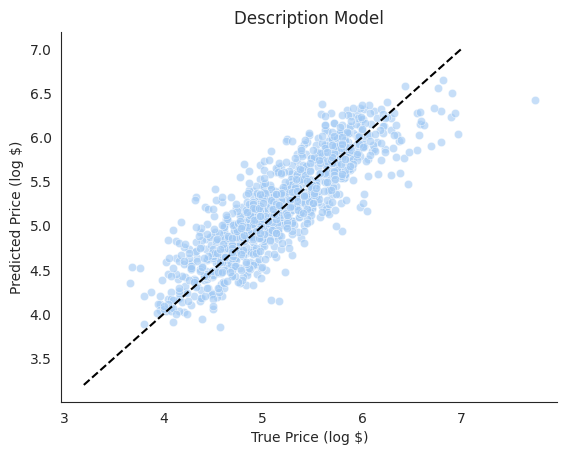

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

predicted =  predictions.predictions.reshape(-1)
y_test = np.array(tokenized_datasets["test"]["labels"])

# plot the data
sns.set_style("white")
sns.set_palette("pastel")
print(r2_score(y_test, predicted))
sns.scatterplot(x=y_test, y=predicted, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price (log $)")
plt.ylabel("Predicted Price (log $)")
plt.title("Description Model")
sns.despine()
plt.savefig("description_model.png", dpi=200)
plt.show()

In [6]:
model.save_pretrained("model_description")
tokenizer.save_pretrained("tokenizer_description")

('tokenizer_description/tokenizer_config.json',
 'tokenizer_description/special_tokens_map.json',
 'tokenizer_description/vocab.txt',
 'tokenizer_description/added_tokens.json',
 'tokenizer_description/tokenizer.json')

In [8]:
import torch
from google.colab import drive

new_df = pd.read_csv("https://raw.githubusercontent.com/john-zhang-uoft/hotel_price_prediction/main/data/final_data.csv")

new_model = AutoModelForSequenceClassification.from_pretrained("model_description").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("tokenizer_description")

outputs = []
for j in range(new_df.shape[0]):
  inputs = tokenizer(new_df["description"].tolist()[j], return_tensors="pt", padding="max_length", truncation=True)
  inputs = {k:v.to("cuda") for k, v in inputs.items()}
  with torch.no_grad():
    try:
      output = model(**inputs, output_hidden_states=True)
      outputs.append(output.hidden_states[-1][:, 0])
    except:
      print(j)

data = torch.cat(outputs, 0)

In [10]:
np_data = data.cpu().numpy()
features = pd.DataFrame(np_data)
features.to_csv("description_features", index=False)